🚀 Starting model comparison...
🏋️ Training Logistic Regression...
✅ Accuracy for Logistic Regression: 85.00%
----------------------------------------
🏋️ Training Random Forest...
✅ Accuracy for Random Forest: 90.00%
----------------------------------------
🏋️ Training XGBoost...
✅ Accuracy for XGBoost: 95.00%
----------------------------------------
🏋️ Training Voting Classifier...
✅ Accuracy for Voting Classifier: 95.00%
----------------------------------------

🏆 MODEL COMPARISON SUMMARY 🏆
XGBoost                   | Accuracy: 95.00%
Voting Classifier         | Accuracy: 95.00%
Random Forest             | Accuracy: 90.00%
Logistic Regression       | Accuracy: 85.00%

🥇 Best performing model: XGBoost with 95.00% accuracy
💾 Best model saved to 'coupon_classifier_model.joblib'

📊 Detailed Classification Report:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         0
         Mid       1.00      0.90      0.95        10
        High   

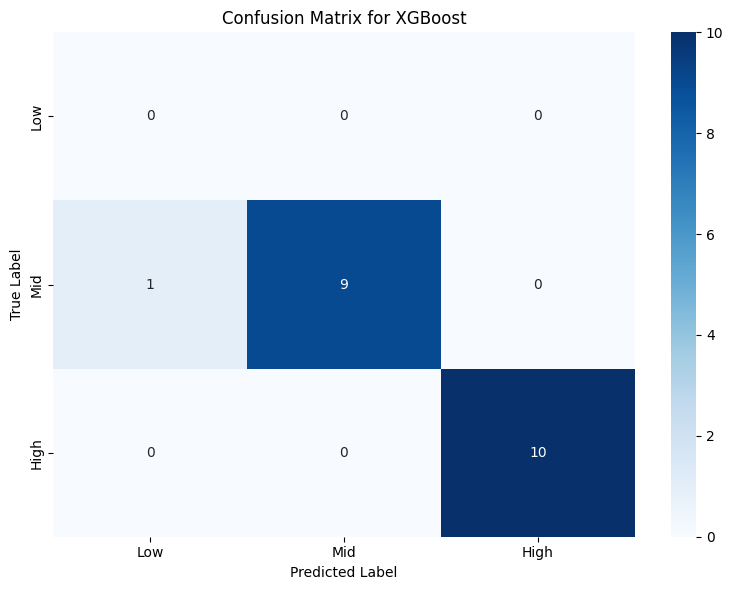


📋 Example Predictions (first 10 users):
user_id               name  total_orders  churn_risk Actual_Tier_Name Predicted_Tier_Name
 SU_200       Ekiya Narain            14        0.69             High                High
 SU_201           Dev Peri            20        0.30             High                High
 SU_202      Theodore Vora            20        0.72             High                High
 SU_203       Chavvi Swamy            10        0.71              Mid                 Mid
 SU_204        Osha Khanna             0        0.84             High                High
 SU_205 Ekalinga Narayanan            19        0.75              Mid                 Mid
 SU_206        Manan Chana             8        0.45              Mid                 Mid
 SU_207        Onveer Guha            12        0.14              Mid                 Mid
 SU_208   Mitesh Chaudhuri            11        0.33              Mid                 Mid
 SU_209        Atharv Peri            20        0.69       

In [32]:
import pandas as pd
import numpy as np
import json
import warnings
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Model Selection & Metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings('ignore')

# --- 1. REFINED LABELING STRATEGY ---
def label_user(row):
    """Assigns a coupon tier based on user behavior and value."""
    # Convert churn_risk to float if it's a string
    churn_risk = float(row['churn_risk']) if isinstance(row['churn_risk'], str) else row['churn_risk']
    
    # High Tier (High-value, high churn risk, or long-time inactive users)
    if churn_risk > 0.8 or row['days_since_last_order'] > 300:
        return 2  # High tier coupon
    
    # Mid Tier (Regular users with moderate engagement)
    elif (row['total_orders'] > 10 and row['sentiment_score'] and row['sentiment_score'] > 0) or \
         (row['total_orders'] > 5 and row['days_since_last_order'] < 100):
        return 1  # Mid tier coupon
    
    # Low Tier (New users or low engagement)
    elif row['account_age_days'] < 90 or row['total_orders'] <= 3:
        return 0  # Low tier coupon
    
    # Default to Mid for moderately engaged users
    else:
        return 1

def train_and_evaluate():
    # --- DATA LOADING ---
    try:
        with open('train_Userlog.json', 'r') as f:
            train_data = json.load(f)
        with open('test_Userlog.json', 'r') as f:
            test_data = json.load(f)
    except FileNotFoundError as e:
        print(f"❌ Error: Make sure '{e.filename}' is in the same directory as the script.")
        return

    train_df = pd.json_normalize(train_data['user_logs'])
    test_df = pd.json_normalize(test_data['user_logs'])

    # --- 2. ENHANCED FEATURE ENGINEERING ---
    for df in [train_df, test_df]:
        # Convert string columns to numeric where needed
        df['churn_risk'] = pd.to_numeric(df['churn_risk'], errors='coerce').fillna(0)
        df['days_since_last_order'] = pd.to_numeric(df['days_since_last_order'], errors='coerce').fillna(0)
        df['total_orders'] = pd.to_numeric(df['total_orders'], errors='coerce').fillna(0)
        df['sentiment_score'] = pd.to_numeric(df['sentiment_score'], errors='coerce')
        df['app_rating'] = pd.to_numeric(df['app_rating'], errors='coerce')
        
        # Date processing
        df['registration_date'] = pd.to_datetime(df['registration_date'])
        df['last_login'] = pd.to_datetime(df['last_login'])
        df['last_order_date'] = pd.to_datetime(df['last_order_date'])
        
        today = pd.to_datetime('2025-07-31')
        df['account_age_days'] = (today - df['registration_date']).dt.days
        df['days_since_last_login'] = (today - df['last_login']).dt.days
        
        # Fill missing values
        df['app_rating'] = df['app_rating'].fillna(df['app_rating'].median())
        df['sentiment_score'] = df['sentiment_score'].fillna(0)
        
        # Create engagement features
        df['order_frequency'] = df['total_orders'] / (df['account_age_days'] + 1) * 365  # orders per year
        df['recent_activity'] = (df['days_since_last_order'] < 30).astype(int)
        df['high_value_user'] = (df['total_orders'] > df['total_orders'].quantile(0.75)).astype(int)
        
        # Category features
        df['num_preferred_categories'] = df['preferred_categories'].apply(len)
        df['prefers_electronics'] = df['preferred_categories'].apply(lambda x: 'Electronics' in x).astype(int)
        df['prefers_metals'] = df['preferred_categories'].apply(lambda x: 'Metals' in x).astype(int)
        df['prefers_paper'] = df['preferred_categories'].apply(lambda x: 'Paper' in x).astype(int)
        df['prefers_plastic'] = df['preferred_categories'].apply(lambda x: 'Plastic' in x).astype(int)
        df['prefers_cardboard'] = df['preferred_categories'].apply(lambda x: 'Cardboard' in x).astype(int)
        df['prefers_vehicles'] = df['preferred_categories'].apply(lambda x: 'Vehicles' in x).astype(int)
        
        # Risk and engagement scores
        df['engagement_score'] = (
            df['total_orders'] / 10 +  # Normalize orders
            (5 - df['days_since_last_order'] / 100) +  # Recent activity bonus
            df['sentiment_score'].fillna(0) +  # Sentiment
            df['app_rating'] / 5  # App rating
        )
        
        # Binary features
        df['has_feedback'] = df['has_given_feedback'].astype(int)
        df['positive_sentiment'] = (df['sentiment_score'] > 0).astype(int)
        df['negative_sentiment'] = (df['sentiment_score'] < 0).astype(int)
        df['high_churn_risk'] = (df['churn_risk'] > 0.7).astype(int)

    # --- LABELING FOR TRAINING ---
    train_df['label'] = train_df.apply(label_user, axis=1)

    # For the test set, we need to create mock labels since the original code expects them
    # In a real scenario, you would have actual ground truth labels
    test_df['label'] = test_df.apply(label_user, axis=1)

    # --- DATA PREPARATION ---
    features_to_drop = [
        'user_id', 'name', 'phone', 'email', 'registration_date',
        'last_login', 'last_order_date', 'preferred_categories',
        'location.city', 'location.area', 'location.pincode'
    ]
    
    X_train = train_df.drop(columns=features_to_drop + ['label'], errors='ignore')
    y_train = train_df['label']
    X_test = test_df.drop(columns=features_to_drop + ['label'], errors='ignore')
    y_test = test_df['label']  # Using our generated labels for evaluation

    # Select features for modeling
    categorical_features = ['user_type']
    numerical_features = [
        'total_orders', 'app_rating', 'sentiment_score', 'days_since_last_order',
        'churn_risk', 'account_age_days', 'days_since_last_login', 'order_frequency',
        'recent_activity', 'high_value_user', 'num_preferred_categories',
        'prefers_electronics', 'prefers_metals', 'prefers_paper', 'prefers_plastic',
        'prefers_cardboard', 'prefers_vehicles', 'engagement_score', 'has_feedback',
        'positive_sentiment', 'negative_sentiment', 'high_churn_risk'
    ]
    
    # Ensure all features exist
    available_features = X_train.columns.tolist()
    categorical_features = [f for f in categorical_features if f in available_features]
    numerical_features = [f for f in numerical_features if f in available_features]
    
    # Create final feature set
    X_train = X_train[numerical_features + categorical_features]
    X_test = X_test[numerical_features + categorical_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ], remainder='passthrough'
    )

    # --- 3. SETUP MODELS FOR COMPARISON ---
    lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    rf = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=2, 
                               class_weight='balanced', random_state=42)
    xgb = XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=5, 
                       use_label_encoder=False, eval_metric='mlogloss', random_state=42)

    voting_clf = VotingClassifier(
        estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)], 
        voting='soft'
    )

    models_to_compare = {
        "Logistic Regression": Pipeline([('preprocessor', preprocessor), ('classifier', lr)]),
        "Random Forest": Pipeline([('preprocessor', preprocessor), ('classifier', rf)]),
        "XGBoost": Pipeline([('preprocessor', preprocessor), ('classifier', xgb)]),
        "Voting Classifier": Pipeline([('preprocessor', preprocessor), ('classifier', voting_clf)])
    }

    # --- TRAIN, EVALUATE, AND COMPARE ---
    results = {}
    best_model_info = {'name': '', 'model': None, 'accuracy': 0, 'predictions': None}
    
    print("🚀 Starting model comparison...\n" + "="*50)
    
    for name, model in models_to_compare.items():
        print(f"🏋️ Training {name}...")
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            results[name] = acc
            print(f"✅ Accuracy for {name}: {acc:.2%}")
            
            if acc > best_model_info['accuracy']:
                best_model_info.update({
                    'name': name,
                    'model': model,
                    'accuracy': acc,
                    'predictions': y_pred
                })
        except Exception as e:
            print(f"❌ Error training {name}: {str(e)}")
        print("-" * 40)

    # --- FINAL RESULTS ---
    print("\n🏆 MODEL COMPARISON SUMMARY 🏆")
    for name, acc in sorted(results.items(), key=lambda item: item[1], reverse=True):
        print(f"{name:<25} | Accuracy: {acc:.2%}")

    if best_model_info['model']:
        print(f"\n🥇 Best performing model: {best_model_info['name']} with {best_model_info['accuracy']:.2%} accuracy")
        
        # Save the best model
        joblib.dump(best_model_info['model'], 'coupon_classifier_model.joblib')
        print(f"💾 Best model saved to 'coupon_classifier_model.joblib'")

        # Detailed report
        print("\n📊 Detailed Classification Report:")
        print(classification_report(y_test, best_model_info['predictions'], 
                                  labels=[0, 1, 2], target_names=['Low', 'Mid', 'High']))

        # Show label distribution
        print(f"\n📈 Label Distribution:")
        print(f"Training set: {np.bincount(y_train)}")
        print(f"Test set: {np.bincount(y_test)}")
        print(f"Predictions: {np.bincount(best_model_info['predictions'])}")

        # Confusion Matrix
        cm = confusion_matrix(y_test, best_model_info['predictions'], labels=[0, 1, 2])
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Low', 'Mid', 'High'], 
                    yticklabels=['Low', 'Mid', 'High'])
        plt.title(f'Confusion Matrix for {best_model_info["name"]}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        # Example predictions
        print("\n📋 Example Predictions (first 10 users):")
        result_df = test_df[['user_id', 'name', 'total_orders', 'churn_risk', 'days_since_last_order']].copy()
        result_df['Predicted_Tier'] = best_model_info['predictions']
        result_df['Actual_Tier'] = y_test
        tier_names = {0: 'Low', 1: 'Mid', 2: 'High'}
        result_df['Predicted_Tier_Name'] = result_df['Predicted_Tier'].map(tier_names)
        result_df['Actual_Tier_Name'] = result_df['Actual_Tier'].map(tier_names)
        print(result_df[['user_id', 'name', 'total_orders', 'churn_risk', 
                        'Actual_Tier_Name', 'Predicted_Tier_Name']].head(10).to_string(index=False))

if __name__ == '__main__':
    train_and_evaluate()